In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

2022-11-27 06:00:57.698216: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_path = './clothing-dataset-small/train/t-shirt'
file = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
image = f'{train_path}/{file}'

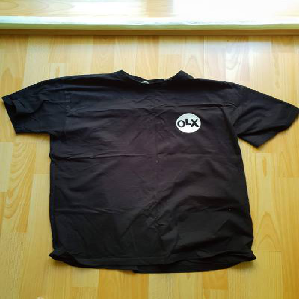

In [3]:
# loading the image
load_img(image, target_size=(299,299))

In [4]:
image = load_img(image, target_size=(299,299))

In [5]:
image_arr = np.array(image)
image_arr.shape

(299, 299, 3)

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [7]:
model = Xception(weights='imagenet', input_shape=(299,299,3))

2022-11-27 06:01:04.105259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 06:01:04.111672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 06:01:04.112308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 06:01:04.113231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [8]:
X = np.array([image_arr])
X_ = preprocess_input(X)
pred = model.predict(X_)

2022-11-27 06:01:07.608666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-27 06:01:08.238494: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-27 06:01:08.239333: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-27 06:01:08.239373: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-27 06:01:08.240328: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-27 06:01:08.240410: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


In [11]:
# probability that image belongs to 1000 classes
pred.shape

(1, 1000)

In [12]:
# decode the predictions
decode_predictions(pred)

[[('n03595614', 'jersey', 0.6792451),
  ('n02916936', 'bulletproof_vest', 0.03960026),
  ('n04370456', 'sweatshirt', 0.035299566),
  ('n03710637', 'maillot', 0.010884127),
  ('n04525038', 'velvet', 0.0018057587)]]

Transfer learning. The exception model already provides good feature map from convulational layer, but the dense layer lacks weighths and inputs to Tshirts. Hence we will take the convulational layer and apply the new dense layer for our models

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train/',
                              target_size=(150,150),
                              batch_size=32)

Found 3068 images belonging to 10 classes.


In [16]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [17]:
# Have a look at the first batch
X, y = next(train_ds)
X.shape

(32, 150, 150, 3)

In [18]:
# For validation layer we dont care the order of images
val_ds = train_gen.flow_from_directory(directory='./clothing-dataset-small/validation/',
                                       target_size=(150, 150),
                                       batch_size=32,
                                       shuffle=False
                                       )

Found 341 images belonging to 10 classes.


In [19]:
# Lets get the base model
base_model = Xception(include_top=False, # We only want the convulational layer and not the dense layer
                 weights='imagenet', 
                 input_shape=(150, 150, 3)
                )
base_model.trainable = False # We only want to train the dense layer

In [20]:
from tensorflow import keras

In [22]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [23]:
inputs = keras.Input(shape=(150, 150,3))
base = base_model(inputs)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(units=len(train_ds.class_indices))(vectors)

model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 18s 159ms/step - loss: 1.1051 - accuracy: 0.6222 - val_loss: 0.7463 - val_accuracy: 0.7507
Epoch 2/10
96/96 [==============================] - 12s 122ms/step - loss: 0.6381 - accuracy: 0.7774 - val_loss: 0.6495 - val_accuracy: 0.7801
Epoch 3/10
96/96 [==============================] - 12s 122ms/step - loss: 0.5112 - accuracy: 0.8305 - val_loss: 0.6012 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 12s 121ms/step - loss: 0.4328 - accuracy: 0.8589 - val_loss: 0.5912 - val_accuracy: 0.7977
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.3720 - accuracy: 0.8862 - val_loss: 0.5657 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.3292 - accuracy: 0.9078 - val_loss: 0.5572 - val_accuracy: 0.8182
Epoch 7/10
96/96 [==============================] - 12s 121ms/step - loss: 0.2933 - accuracy: 0.9221 - val_loss: 0.5567 - val_accuracy: 0.8270

In [24]:
preds = model.predict(X)
preds

1/1 [==============================] - 1s 627ms/step


array([[  4.290159  ,  -8.480732  ,  -2.394664  ,  -2.5544972 ,
         -5.194379  ,  -3.0113966 ,  -5.518653  ,  -5.2083054 ,
         -3.3163118 ,   0.01716609],
       [ -1.6411533 ,  -7.276846  ,  -2.574195  ,  -4.150035  ,
         -2.844448  ,  -4.049609  ,  -5.5821953 ,  -6.786447  ,
         -3.9997811 ,   3.658215  ],
       [ -2.1042707 ,  -7.7268744 ,   1.5623982 ,  -7.2756577 ,
        -10.117089  ,  -1.5030307 ,  -9.379417  ,  -5.681634  ,
        -10.663782  ,   4.251247  ],
       [ -2.854555  ,  -9.614577  ,   0.6247106 ,  -1.9408295 ,
         -6.354634  ,  -4.491529  , -13.216399  ,  -6.2835665 ,
         -8.577178  ,  -3.3250754 ],
       [  0.6916642 , -10.963697  ,  -4.458911  ,  -6.054317  ,
         -9.41939   ,  -1.9279034 ,  -9.784767  ,  -4.669139  ,
         -7.0501423 ,  -0.81775534],
       [  1.3723993 ,  -1.0024745 ,  -3.662943  ,  -6.422966  ,
         -5.627503  ,  -1.5215605 ,  -4.9353757 ,  -6.658739  ,
         -7.188026  ,  -4.586504  ],
       [ -

In [25]:
def train_fashion_classifier(learning_rate=0.1):
    """Function to train and optimize learning rate"""

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(units=10)(vectors)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [60]:
%%time
scores = {}
for lr in [0.01, 0.001]:
    print(lr)
    
    model = train_fashion_classifier(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    
    scores[lr] = history.history
    print()
    print()

0.01
Epoch 1/10
96/96 [==============================] - 15s 131ms/step - loss: 1.2493 - accuracy: 0.6656 - val_loss: 0.9532 - val_accuracy: 0.7507
Epoch 2/10
96/96 [==============================] - 12s 122ms/step - loss: 0.6123 - accuracy: 0.8113 - val_loss: 0.8693 - val_accuracy: 0.7830
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3322 - accuracy: 0.8849 - val_loss: 0.9283 - val_accuracy: 0.7830
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 0.2517 - accuracy: 0.9136 - val_loss: 0.8006 - val_accuracy: 0.7771
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.1547 - accuracy: 0.9449 - val_loss: 0.8289 - val_accuracy: 0.8152
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.0981 - accuracy: 0.9690 - val_loss: 0.8708 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 12s 122ms/step - loss: 0.1093 - accuracy: 0.9599 - val_loss: 0.9620 - val_accuracy: 0

In [31]:
import matplotlib.pyplot as plt

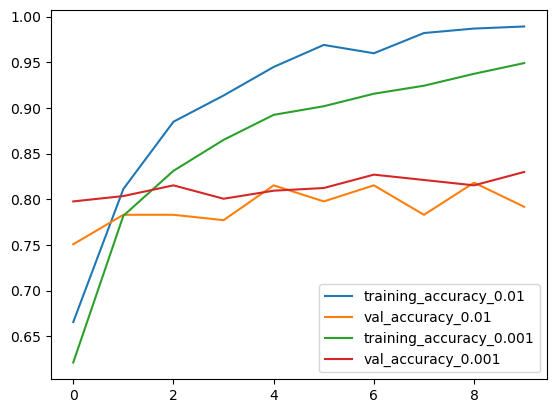

In [64]:
#del scores[0.1]
#del scores[0.0001]
for lr in [0.01, 0.001]:
    plt.plot(scores[lr]['accuracy'], label=f'training_accuracy_{str(lr)}')
    plt.plot(scores[lr]['val_accuracy'], label=f'val_accuracy_{str(lr)}')
    plt.legend()

In [26]:
#model.save_weights('model_v1.h5', save_format='h5')
checkpoint = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
                                             save_best_only=True, 
                                             monitor='val_accuracy', 
                                             mode='max' 
                                            )

In [68]:
# Using checkpoint to only save the best results
learning_rate = 0.001    
model = train_fashion_classifier(learning_rate=lr)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10
96/96 [==============================] - 15s 135ms/step - loss: 1.0817 - accuracy: 0.6327 - val_loss: 0.7033 - val_accuracy: 0.7889
Epoch 2/10
96/96 [==============================] - 12s 125ms/step - loss: 0.6304 - accuracy: 0.7901 - val_loss: 0.6147 - val_accuracy: 0.8123
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 0.5023 - accuracy: 0.8289 - val_loss: 0.5715 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 12s 126ms/step - loss: 0.4293 - accuracy: 0.8638 - val_loss: 0.5592 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3725 - accuracy: 0.8856 - val_loss: 0.5814 - val_accuracy: 0.8006
Epoch 6/10
96/96 [==============================] - 12s 124ms/step - loss: 0.3247 - accuracy: 0.9084 - val_loss: 0.5607 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2872 - accuracy: 0.9237 - val_loss: 0.5259 - val_accuracy: 0.8328

In [27]:
def train_fashion_classifier_v2(learning_rate=0.1, size_inner=10):
    """Function to train and optimize learning rate"""

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(units=size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(units=10)(inner)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [71]:
%%time
scores = {}
learning_rate = 0.001
for size in [10,100,1000]:
    print(size)
    
    model = train_fashion_classifier_v2(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    
    scores[size] = history.history
    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 15s 131ms/step - loss: 1.3508 - accuracy: 0.5704 - val_loss: 0.9242 - val_accuracy: 0.7185
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 0.7643 - accuracy: 0.7520 - val_loss: 0.6813 - val_accuracy: 0.7713
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.6054 - accuracy: 0.7927 - val_loss: 0.6249 - val_accuracy: 0.8035
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.4964 - accuracy: 0.8396 - val_loss: 0.5799 - val_accuracy: 0.8123
Epoch 5/10
96/96 [==============================] - 12s 121ms/step - loss: 0.4291 - accuracy: 0.8651 - val_loss: 0.5869 - val_accuracy: 0.8035
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.3696 - accuracy: 0.8827 - val_loss: 0.5576 - val_accuracy: 0.8094
Epoch 7/10
96/96 [==============================] - 12s 124ms/step - loss: 0.3220 - accuracy: 0.9068 - val_loss: 0.5662 - val_accuracy: 0.8

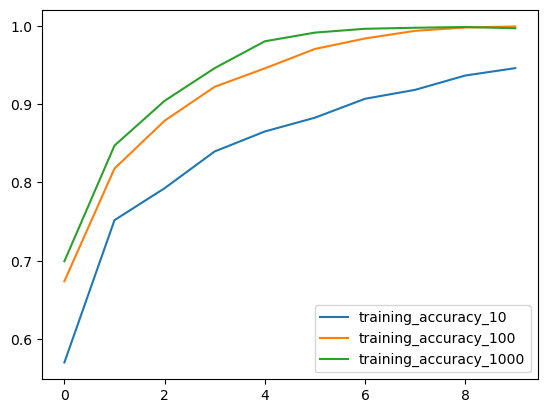

In [72]:
# visualising the training scores data
for size in [10,100,1000]:
    plt.plot(scores[size]['accuracy'], label=f'training_accuracy_{str(size)}')
    plt.legend()

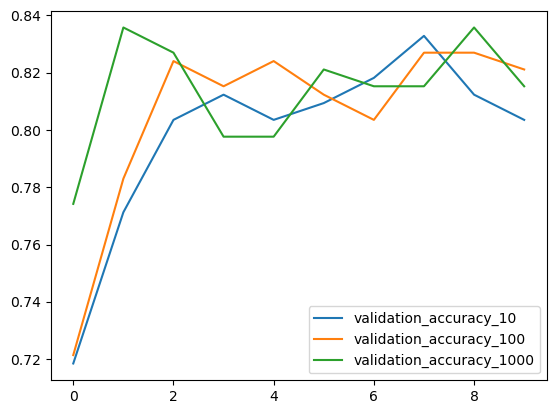

In [73]:
# visualising the validation scores data
for size in [10,100,1000]:
    plt.plot(scores[size]['val_accuracy'], label=f'validation_accuracy_{str(size)}')
    plt.legend()

In [28]:
def train_fashion_classifier_v3(learning_rate=0.1, size_inner=10, drop_rate=0.5):
    """Function to train and optimize learning rate"""

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(units=size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(rate=drop_rate, seed=1)(inner)
    outputs = keras.layers.Dense(units=10)(drop)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [29]:
learning_rate = 0.001
size = 1000
scores = {}

for dr in [0.0, 0.2, 0.5, 0.8]:
    print(dr)
    
    model = train_fashion_classifier_v3(learning_rate=learning_rate, size_inner=size, drop_rate=dr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[dr] = history.history
    
    print()
    print()

0.0
Epoch 1/10
96/96 [==============================] - 15s 130ms/step - loss: 0.9586 - accuracy: 0.6812 - val_loss: 0.7317 - val_accuracy: 0.7419
Epoch 2/10
96/96 [==============================] - 12s 121ms/step - loss: 0.4350 - accuracy: 0.8510 - val_loss: 0.6468 - val_accuracy: 0.7713
Epoch 3/10
96/96 [==============================] - 12s 122ms/step - loss: 0.2755 - accuracy: 0.9097 - val_loss: 0.5865 - val_accuracy: 0.8035
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 0.1613 - accuracy: 0.9465 - val_loss: 0.6292 - val_accuracy: 0.8035
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.0987 - accuracy: 0.9739 - val_loss: 0.6052 - val_accuracy: 0.8328
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0488 - accuracy: 0.9922 - val_loss: 0.7127 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0398 - accuracy: 0.9928 - val_loss: 0.6520 - val_accuracy: 0.

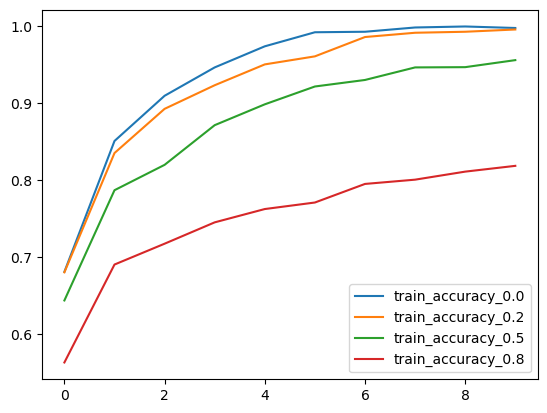

In [33]:
for dr in [0.0, 0.2, 0.5, 0.8]:
    plt.plot(scores[dr]['accuracy'], label=f'train_accuracy_{str(dr)}')
    plt.legend()

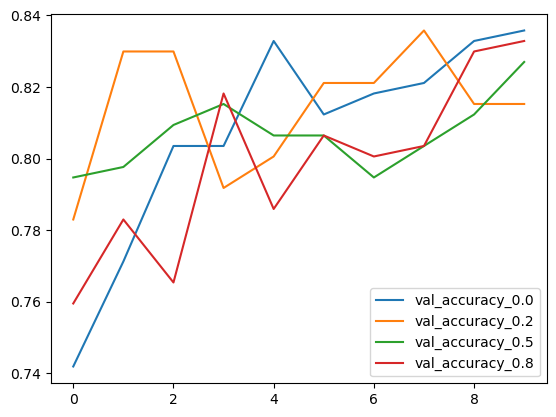

In [34]:
for dr in [0.0, 0.2, 0.5, 0.8]:
    plt.plot(scores[dr]['val_accuracy'], label=f'val_accuracy_{str(dr)}')
    plt.legend()

In [39]:
# lets choose drop out rate as 0.2
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=1.0,
                               zoom_range=0.2,
                               vertical_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train/',
                              target_size=(150,150),
                              batch_size=32)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/',
                              target_size=(150,150),
                              batch_size=32,
                              shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [40]:
learning_rate = 0.001
size = 1000
drop_rate = 0.2

model = train_fashion_classifier_v3(learning_rate=learning_rate, size_inner=size, drop_rate=drop_rate)
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
96/96 [==============================] - 27s 254ms/step - loss: 1.2089 - accuracy: 0.6092 - val_loss: 0.7119 - val_accuracy: 0.7595
Epoch 2/5
96/96 [==============================] - 24s 248ms/step - loss: 0.8098 - accuracy: 0.7197 - val_loss: 0.6615 - val_accuracy: 0.7595
Epoch 3/5
96/96 [==============================] - 24s 247ms/step - loss: 0.7284 - accuracy: 0.7516 - val_loss: 0.7399 - val_accuracy: 0.7302
Epoch 4/5
96/96 [==============================] - 24s 246ms/step - loss: 0.6678 - accuracy: 0.7673 - val_loss: 0.6155 - val_accuracy: 0.7918
Epoch 5/5
96/96 [==============================] - 24s 245ms/step - loss: 0.5874 - accuracy: 0.8002 - val_loss: 0.6228 - val_accuracy: 0.7947


In [42]:
# Lets train the large network
input_size = 299
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=2.0,
                               zoom_range=0.2,
                               vertical_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train/',
                              target_size=(input_size,input_size),
                              batch_size=32)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/',
                              target_size=(input_size,input_size),
                              batch_size=32,
                              shuffle=False)

checkpoint = keras.callbacks.ModelCheckpoint('xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
                                             save_best_only=True, 
                                             monitor='val_accuracy', 
                                             mode='max' 
                                            )

base_model = Xception(include_top=False, # We only want the convulational layer and not the dense layer
                 weights='imagenet', 
                 input_shape=(input_size, input_size, 3)
                )
base_model.trainable = False # We only want to train the dense layer


def train_fashion_classifier_v4(input_size=150, learning_rate=0.1, size_inner=10, drop_rate=0.5):
    """Function to train and optimize learning rate"""

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(units=size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(rate=drop_rate, seed=1)(inner)
    outputs = keras.layers.Dense(units=10)(drop)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model


learning_rate = 0.005
size = 1000
drop_rate = 0.2

model = train_fashion_classifier_v4(input_size=input_size, learning_rate=learning_rate, size_inner=size, drop_rate=drop_rate)
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Epoch 1/30
96/96 [==============================] - 69s 679ms/step - loss: 1.1238 - accuracy: 0.6711 - val_loss: 0.5778 - val_accuracy: 0.7918
Epoch 2/30
96/96 [==============================] - 63s 658ms/step - loss: 0.6671 - accuracy: 0.7689 - val_loss: 0.4783 - val_accuracy: 0.8270
Epoch 3/30
96/96 [==============================] - 64s 669ms/step - loss: 0.6059 - accuracy: 0.7920 - val_loss: 0.5146 - val_accuracy: 0.8182
Epoch 4/30
96/96 [==============================] - 63s 658ms/step - loss: 0.5304 - accuracy: 0.8110 - val_loss: 0.4908 - val_accuracy: 0.8270
Epoch 5/30
96/96 [==============================] - 63s 652ms/step - loss: 0.5156 - accuracy: 0.8295 - val_loss: 0.5544 - val_accuracy: 0.7918
Epoch 6/30
96/96 [==============================] - 64s 666ms/step - loss: 0.4632 - accuracy: 0.8383 - val_loss: 0.5125 - val_accuracy: 0.8240
Epoch 7/30
96/96 [==============================] - 64s 6

In [43]:
# Using the model
model = keras.models.load_model('xception_v4_16_0.868.h5')

In [44]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_ds = test_gen.flow_from_directory('./clothing-dataset-small/test/',
                              target_size=(input_size,input_size),
                              batch_size=32,
                              shuffle=False)

Found 372 images belonging to 10 classes.


In [45]:
# Evaluate the model
model.evaluate(test_ds)

12/12 [==============================] - 4s 277ms/step - loss: 0.4502 - accuracy: 0.8468


[0.4501709043979645, 0.8467742204666138]

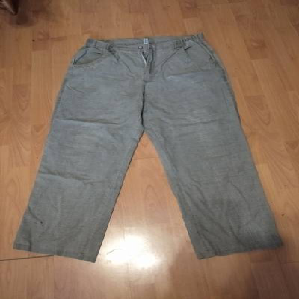

In [47]:
# Lets get an image of pants
image = load_img(path='./clothing-dataset-small/test/pants/122f0c94-4f37-4010-8c43-06d79bdf4433.jpg', target_size=(input_size, input_size))
image

In [50]:
# Preprocessing the image
X = np.array(image)
X_ = np.array([X])
X_ = preprocess_input(X_)

In [52]:
# Predicting the image
pred = model.predict(X_)
pred[0]

1/1 [==============================] - 0s 22ms/step


array([ -3.6871798, -10.975215 ,  -4.8468695,  -2.5357308,   8.144001 ,
        -6.8084497,  -8.036953 ,   3.0427997,  -0.340798 ,  -6.499965 ],
      dtype=float32)

In [61]:
# classes
classes = list(train_ds.class_indices.keys())
pred_classes = dict(zip(classes, pred[0]))

In [64]:
# Predictions
{k: v for k, v in sorted(pred_classes.items(), key=lambda item: item[1], reverse=True)}

{'pants': 8.144001,
 'shorts': 3.0427997,
 'skirt': -0.340798,
 'outwear': -2.5357308,
 'dress': -3.6871798,
 'longsleeve': -4.8468695,
 't-shirt': -6.499965,
 'shirt': -6.8084497,
 'shoes': -8.036953,
 'hat': -10.975215}